<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Shamith/IT22586902_Anec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn matplotlib seaborn pillow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset located at: /content/drive/MyDrive/AneN_Dasaset
Contents of /content/drive/MyDrive/AneN_Dasaset:
['Healthy_individuals', 'Anemic_individuals']


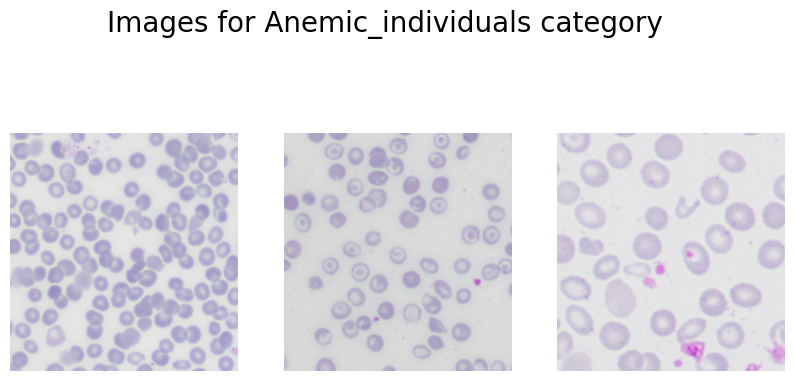

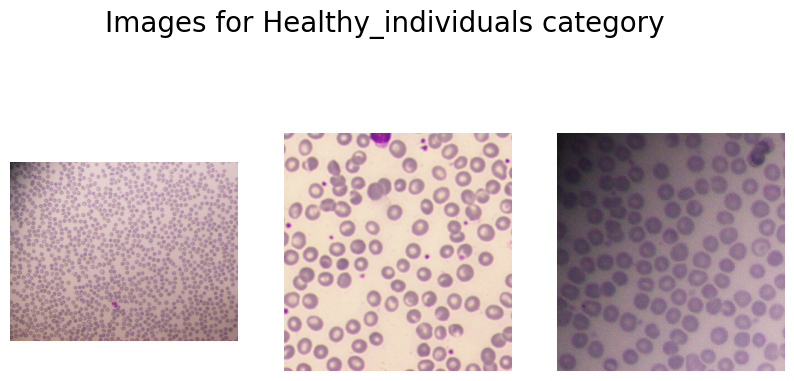

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -----------------------------------------------------------
# Define Dataset Path
# -----------------------------------------------------------
data_base_path = '/content/drive/MyDrive/AneN_Dasaset'

# The dataset is already a directory, no extraction needed.
print(f'Dataset located at: {data_base_path}')

# --- Debugging: List contents of the base path ---
print(f'Contents of {data_base_path}:')
try:
    top_level_contents = os.listdir(data_base_path)
    print(top_level_contents)
except FileNotFoundError:
    print(f'Error: Base path {data_base_path} not found.')
# --------------------------------------------------

# Adjusting path and classes based on actual directory contents
path = data_base_path # The main dataset directory
classes = ['Anemic_individuals', 'Healthy_individuals'] # These are the actual category folders

for cat in classes:
    image_dir = os.path.join(path, cat)

    # --- Debugging: Check if image_dir exists before listing ---
    if not os.path.exists(image_dir):
        print(f'Error: Directory {image_dir} not found. Please check dataset structure.')
        continue
    # ------------------------------------------------------------

    images = os.listdir(image_dir)

    # Only proceed to plot if there are images
    if images:
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle(f'Images for {cat} category', fontsize=20)

        for i in range(min(3, len(images))):
            k = np.random.randint(0, len(images))
            img = np.array(Image.open(os.path.join(image_dir, images[k])))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()
    else:
        print(f'No images found in {image_dir}.')

In [ ]:
import os

# List everything in the dataset root
dataset_root = path
print("Contents of dataset root:", os.listdir(dataset_root))

# If there's a single folder inside, go one level deeper
for item in os.listdir(dataset_root):
    item_path = os.path.join(dataset_root, item)
    if os.path.isdir(item_path):
        print(f"Contents of {item}:", os.listdir(item_path))

Contents of dataset root: ['Healthy_individuals', 'Anemic_individuals']
Contents of Healthy_individuals: ['008_h.png', '011_h.png', '010_h.png', '007_h.png', '031_h.png', '020_h.png', '024_h.png', '021_h.png', '036_h.png', '019_h.png', '034_h.png', '022_h.png', '032_h.png', '033_h.png', '035_h.png', '023_h.png', '046_h.png', '047_h.png', '044_h.png', '043_h.png', '042_h.png', '045_h.png', '064_h.png', '063_h.png', '060_h.png', '059_h.png', '061_h.png', '062_h.png', '075_h.png', '072_h.png', '076_h.png', '073_h.png', '077_h.png', '074_h.png', '089_h.png', '094_h.png', '082_h.png', '092_h.png', '093_h.png', '081_h.png', '090_h.png', '079_h.png', '078_h.png', '080_h.png', '091_h.png', '097_h.png', '096_h.png', '101_h.png', '108_h.png', '111_h.png', '109_h.png', '100_h.png', '112_h.png', '120_h.png', '098_h.png', '099_h.png', '113_h.png', '110_h.png', '141_h.png', '142_h.png', '143_h.png', '129_h.png', '132_h.png', '131_h.png', '139_h.png', '140_h.png', '128_h.png', '130_h.png', '127_h.png

In [ ]:
# Correct dataset path
dataset_folder = path # `path` already holds '/content/drive/MyDrive/AneDasaset'

# Check what’s inside
print("Contents of dataset root:", os.listdir(dataset_folder))

Contents of dataset root: ['Healthy_individuals', 'Anemic_individuals']


In [ ]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 256
NUM_CLASSES = 2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = dataset_folder
test_dir = dataset_folder # Assuming the test data is also within the same base folder structure

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1624 images belonging to 2 classes.
Found 405 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

NUM_CLASSES = 2  # binary classification

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(160,160,3)
)
base_model.trainable = False  # freeze base for transfer learning

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')  # 2 classes
])

In [ ]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,088,658 (23.23 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 291s 42s/step - accuracy: 0.4986 - loss: 0.7700 - val_accuracy: 0.4938 - val_loss: 0.7054
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 293s 42s/step - accuracy: 0.4811 - loss: 0.7585 - val_accuracy: 0.4938 - val_loss: 0.7036
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 248s 35s/step - accuracy: 0.4861 - loss: 0.7610 - val_accuracy: 0.4938 - val_loss: 0.6979
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 286s 45s/step - accuracy: 0.4813 - loss: 0.7502 - val_accuracy: 0.4938 - val_loss: 0.6976
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 252s 36s/step - accuracy: 0.4921 - loss: 0.7517 - val_accuracy: 0.4938 - val_loss: 0.6990
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 255s 40s/step - accuracy: 0.4674 - loss: 0.7562 - val_accuracy: 0.4938 - val_loss: 0.6972
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 251s 36s/step - accuracy: 0.5150 - loss: 0.7214 - val_accuracy: 0.4938 - val_loss: 0.6963
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 252s 36s/step - accuracy: 0.4841 - loss: 0.7446 - val_accuracy: 0.4938 - val_loss:

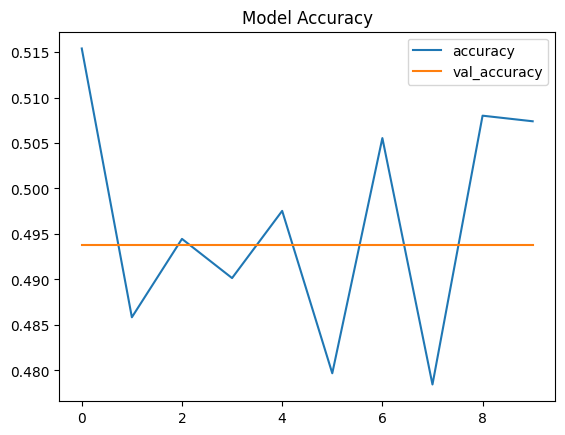

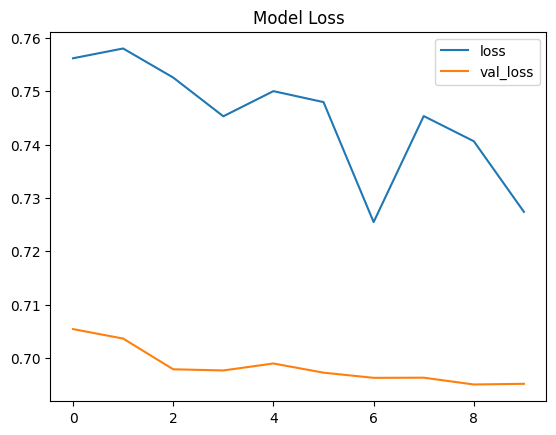

In [ ]:
# -----------------------------------------------------------
# Plot Accuracy and Loss
# -----------------------------------------------------------
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Model Accuracy")
plt.show()

history_df.loc[:, ['loss', 'val_loss']].plot(title="Model Loss")
plt.show()


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 961s 132s/step - accuracy: 0.4895 - loss: 1.0443 - val_accuracy: 0.5062 - val_loss: 0.6930
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 875s 123s/step - accuracy: 0.4914 - loss: 1.0044 - val_accuracy: 0.5062 - val_loss: 0.6975
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 870s 122s/step - accuracy: 0.5123 - loss: 0.9032 - val_accuracy: 0.5062 - val_loss: 0.6989
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 926s 123s/step - accuracy: 0.4935 - loss: 0.9333 - val_accuracy: 0.5062 - val_loss: 0.6999
